# Lab 3 - Multimedia Lab

#### Authors:

v1.0 (2014 Fall) Rishi Sharma \*\*\*, Sahaana Suri \*\*\*, Kangwook Lee \*\*\*, Kannan Ramchandran \*\*\*   
v1.1 (2015 Fall) Kabir Chandrasekher \*\*, Max Kanwal \*\*, Kangwook Lee \*\*\*, Kannan Ramchandran \*\*\*  
v1.2 (2016 Spring) Ashvin Nair \*, Kabir Chandrasekher \*\*, Kangwook Lee \*\*\*, Kannan Ramchandran \*\*\*

The Multimedia Lab is designed to discuss two aspects of the life-cycle of a multimedia file. This story begins with generation of the file, which is the digitization of some analog phenomenon of interest (e.g. sound -> music, light -> image, both -> film). Once this process is complete, the generated digital media file can be operated on (stored, read, copied, etc.) by a finite precision computer. Each of these operations, however, would be quite a bit easier if the file were small, so we'll investigate compressing the file into a more compact representation.

Naturally, the process of capturing and storing a media file is composed of a harmony of instruments across **all** EECS disciplines, but this lab will focus in particular on the role of probabilistic analysis, reasoning, and algorithm design in this symphony. Probability in EECS does not exist in a vacuum but, as you will see in this lab, often forms the theoretical underpinning to analyze the efficacy of an idea.

## Quantization and Huffman Compression

When capturing media, we must go from a real world analog media to a digital representation. In general, this process is a matter of sampling, quantization, and compression. As technology improves, sampling methods become faster and more precise, quantized representations of media allow for more bits of precision, and both lossy and lossless compression algorithms improve performance. The tools to measure the effectiveness of these improving technologies, however, remain largely the same, and many of them are built on probabilistic analysis.

In this lab, we will talk about quantization for audio signals, and compression of tweets. This should give you an introduction to two of the key aspects of digitally storing media.

## Audio Quantization 

We live in an analog world, where input values may be continous and uncountable. This isn't very useful if we want to do any sort of digital signal processing. What we do instead to deal with this is to create a mapping from our huge set of continuous input values to a smaller set that we can manage. We essentially bucket-off all of our input values before working with them (rounding is a form of quantization as well). However, as you might imagine, by mapping a large set to a smaller one, we introduce some level of quantization error. The amount of distortion you experience will be determined by the method and parameters used during the quantization process. 

In this portion of the lab, we will step you through the process of generating and playing a wav file in iPython. You will then implement a quantizer method, and play the resulting quantized song. We will wrap up this section of the lab by exploring the effects of quantization error.

The following modules and functions will allow you to generate, load, and play a wav file in iPython. You don't need to understand how they work, but you should understand how to use them.

In [4]:
import scipy.constants as const
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
def playMusic(title, rate, music):
    # write the file on disk, and show in in a Html 5 audio player
    music_wav = music * 2**13
    wavfile.write(title + '.wav', rate, music_wav.astype(np.int16))
    wavPlayer(title + '.wav')

### Generating a Song

Each key of a piano can be thought as a sinusoidal wave with a certain frequency. Let us consider the following score of a song, 'School Bell Ringing'. 
<center><img src="http://i.imgur.com/yDS60eM.png" alt="School bell notes"></center>

Let us assume that each note is a half second long sinusoidal wave. Because the song consists of 32 notes, the song is 16 seconds long. If we specify a sampling rate of 44.1 kHz, then our song will have $44100\times16$ samples in the entire song. The frequency associated with each note will be specified by the formula given for <a href="http://en.wikipedia.org/wiki/Piano_key_frequencies">piano key frequencies</a>, namely that the frequency for the $n^\text{th}$ key is given by


$$ {\huge f(n) = 2^{\frac{n-49}{12}}\times 440 \text{Hz} }$$

The list $\operatorname{notes}$ specified below holds the key values $n$ for each note in 'School Bell Ringing' in sequential order.

In [5]:
# C:40, D:42, E:44, F:45, G:47, A:49, B:51, Higher C:52
# 0 represents 'pause'
notes = [47, 47, 49, 49, 47, 47, 44, 44, 47, 47, 44, 44, 42, 42, 42, 0,
         47, 47, 49, 49, 47, 47, 44, 44, 47, 44, 42, 44, 40, 40, 40, 0]

From these $n$ values, we can generate the sinusoids which represent this song as follows:

In [6]:
note_duration = 0.5 # per key, in sec
rate = 44100 #44.1 khz
music_duration = note_duration * len(notes)
time = np.linspace(0, music_duration, num=rate*music_duration) # indices for 0-16 secs spaced apart by 1/44100
song = np.zeros(len(time))

sinwave = lambda f,t : np.sin(2*np.pi*f*t) # generate a sinusoid of frequency f Hz over time t
key2freq = lambda n : 2 ** ((n-49)/12) * 440 # convert a piano key n to a frequency in Hz

idx_note = 0
for note in notes:
    if note: # if note == 0, skip.
        freq = key2freq(note) # frequency of each note
        song[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration] = \
                sinwave( freq,
                        time[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration ] 
                        ) #generates the sinusoids for the song, in .5 sec intervals
    idx_note += 1

/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Now that we've generated the song, let's plot the first 0.01 seconds to see that we actually turned notes into sinusoidal waves.

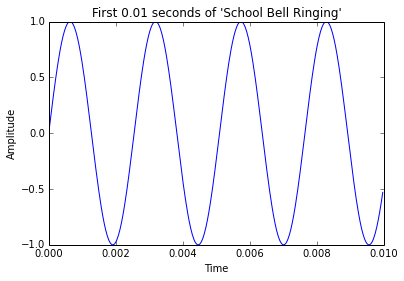

In [7]:
plt.plot(time[0:441], song[0:441]) # Plot the first 0.01 second
plt.title("First 0.01 seconds of 'School Bell Ringing'")
plt.xlabel("Time")
plt.ylabel("Amplitude")

And now, let's listen to the song that's been generated.

In [8]:
playMusic('school_bell_original', rate, song)
print "Wow! What a great song. I should try playing other ones too."

Wow! What a great song. I should try playing other ones too.


## <font color=blue> $\mathcal{Q}$1. Quantize the song</font>
Now for the fun part. We want to quantize this audio signal and analyze the resulting error. We will use an $\ell$-bit uniform-quantizer. We can use only $L = 2^\ell$ quantized values: $\{-1, -\frac{L-3}{L-1}, -\frac{L-5}{L-1}, ..., -\frac{1}{L-1}, \frac{1}{L-1}, ..., \frac{L-5}{L-1}, \frac{L-3}{L-1}, 1\}$ to represent each value of the original signal $-1 \leq x[n] \leq 1$. Our signal only takes values between -1 and 1, so our $\ell$-bit uniform-quantizer allows our signal to take on $2^\ell$ evenly spaced values in the range of interest. Each point in the original signal $x[n]$ is binned according to a nearest neighbor strategy.

### <font color=blue>a. Implement the quantizer method below, under the above conditions.</font>

In [9]:
def quantizer(num_of_bits, original_signal):
    numBins = 2**num_of_bits
    quantized_signal = []
    for fr in original_signal:
        for bin_i in range(1,numBins+1): #Could probably use binary search, actually...
            if(fr <= ((float)(bin_i)) / numBins):
                #print bin_i
                quantized_signal.append((((float)(bin_i - 1)) / (numBins-1) * 2) - 1)
    
    
    return quantized_signal

### <font color=blue>b. What do you expect the quantized signal to look like if <tt> number_of_bits </tt> is set to 1?</font>

1b. The quantized values are just members of {-1, 1}

### <font color=blue>c. Quantize the song using your quantizer.Plot and compare the original signal and the quantized signal. Play around with `num_of_bits` to see how the song changes</font>

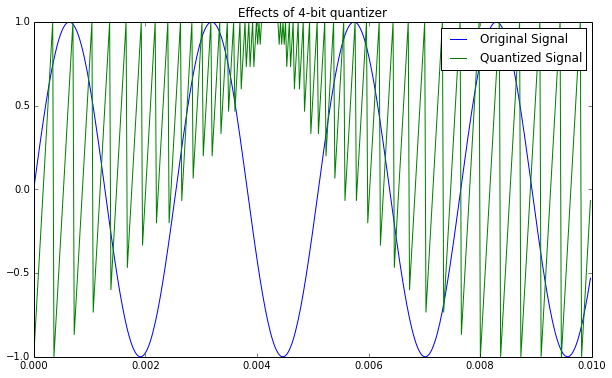

In [10]:
# Solution for 4-bit quantizer should match below
num_of_bits = 4
quantized_song = quantizer(num_of_bits,song)
# Plot the first 0.01 second of songs.
plt.figure(figsize=(10,6))
plt.plot(time[0:441], song[0:441])
plt.plot(time[0:441], quantized_song[0:441])
plt.legend(['Original Signal', 'Quantized Signal'])
plt.title('Effects of ' + str(num_of_bits) + '-bit quantizer')

playMusic('quantized_song_' + str(num_of_bits) + '_bits', rate, quantized_song)

____

As noted before, the difference you are witnessing between the original signal and the quantized signal is the <b>quantization 
error</b>. As confirmed from the previous exercise, the quantization noise is almost negligible if one uses a sufficient number of bits. Let's take a look at the quantization error more carefully.

In [ ]:
# Run code in this cell to see the difference between the original and quantized signals (quantization error)
num_of_bits = 20
quantized_song = quantizer(num_of_bits,song)
plt.plot(time[0:441], song[0:441] - quantized_song[0:441])
plt.title('Quantization Error')

### <font color=blue>d. Plot the mean squared error between the original and quantized signal as a function of number of bits used for a quantizer for $1 \leq \ell \leq 10$</font>

Observe how fast the MSE drops as you increase $\ell$. Is it linearly decreasing? Or is it exponentially decreasing? First plot the MSE, then change the y-axis to a log-scale.

Note: The MSE is the <a href="http://mathworld.wolfram.com/L2-Norm.html">$l^2$-norm</a> squared of the quantization noise divided by the number of noise samples.

In [ ]:
# d. Your Beautiful Code Here

____

You should see that the MSE does indeed drop exponentially! This result was easily confirmed via simulation, so let's do some calculations to obtain the same results via analysis.

## Sampling & Quantization: Analysis

In order to analyze the effect of quantization noise, we need to come up with a good model for the quantization noise. Although everything we did was deterministic, what we saw above was really just one specific realization of quantization. For each sample, the original value was mapped to the nearest quantization point. The distance between the chosen quantization point and the original value became the quantization noise for the sample. But how bad is the error on the whole?

Let's just start by modelling the noise as a <b>uniform random variable</b>. If the original signal is assumed to take each value chosen at uniformly random, the model will be precise. However, is this model also valid for structured signals such as a combination of sinusoidal waves? Let's take a look at a 'noise histogram' to find out. 

In [ ]:
num_of_bits = 8
# time, song = sampler(sampling_rate)
quantized_song = quantizer(num_of_bits, song)
plt.hist( (song - quantized_song ) , 30 );
plt.title('Noise Histogram')
plt.xlabel('Quantization Error')
plt.ylabel('Occurances')

We see that the quantization error is not exactly uniform, but extremely close. There is one value which occurs significantly more frequently than the rest, but that is an artifact of the structure in a sinusoid (they like to hang around -1 and 1 for a while). If we consider general signals, the model of quantization noise as uniform is even more accurate, although it is not too bad in this case either.

### <font color=blue>e. Given that the error between a quantized signal and the original is modeled as a uniform random variable, justify that the MSE will drop exponentially. Find an equation for $\mathbb{E}[\text{MSE}]$ given an arbitrary number of bits $\ell$. On a log scale, plot the expected MSE given the uniform model along with the achieved MSE for the signal above for $1 \leq \ell \leq 10$. Do they decay similarly?</font>

e. Your Solution Here

In [ ]:
# e. Plotting Code Here

_____________

## Compression: Twitter Revolution
Before attempting this section, brush up on (or learn for the first time) <a href="https://www.siggraph.org/education/materials/HyperGraph/video/mpeg/mpegfaq/huffman_tutorial.html">Huffman coding</a>.


Your friend Ben Bitdiddle just returned from Tunisia and wants to start a revolution at UC Berkeley. He knows Twitter can be an important tool for revolution, but it has a major problem: 140 characters just isn't enough. For example, Ben wants to send the tweet:

<blockquote class="twitter-tweet" lang="en"><p lang="en" dir="ltr">grades are a fundamentally oppressive tool used by academic institutions to equate the value of a human being with a letter and a number! pr</p>&mdash; Benjamin Bitdiddle (@benjbitdiddle) <a href="https://twitter.com/benjbitdiddle/status/692246014179295232">January 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
<blockquote class="twitter-tweet" lang="en"><p lang="en" dir="ltr">otest coryhall tonight</p>&mdash; Benjamin Bitdiddle (@benjbitdiddle) <a href="https://twitter.com/benjbitdiddle/status/692246030943920128">January 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>


The tweet exceeded 140 characters and he had to send it at **2 separate tweets**, which dramatically reduces the impact of his revolutionary message. If people read the first tweet, they won't know where the protest is located; if they read the second, they may get to the protest, but they won't know why they are protesting!

Ben has devised a new scheme to _compress_ his tweets so he can fit his longer messages into 140 characters. There are only 24 unique characters which he uses in his tweets, but not all of them occur equally often, so he will use a Huffman code as follows:
1. He will encode his tweet as a binary string using a Huffman code based on the letter frequencies determined by the hash table `freq_dict` below.
2. He will convert this bit-string back into letters according to the `bits2letters` mapping defined below. If the bitstring created by the Huffman code does not have a length which is a multiple of 5, he will append the Huffman code for the character `SPACE` to the bitstring until it _does_ have length which is a multiple of 5.

In [ ]:
english_freq_dict = {'!': 0.0008, "'": 0.0004, ' ': 0.1033, ',': 0.0011,\
             '.': 0.0011, '?': 0.0006, 'a': 0.069, 'c': 0.027000000000000003,\
             'b': 0.013999999999999999, 'e': 0.1, 'd': 0.039, 'g': 0.021, 'f': 0.022000000000000002,\
             'i': 0.06, 'h': 0.048, 'k': 0.008, 'j': 0.0014000000000000002, 'm': 0.025,\
             'l': 0.043, 'o': 0.065, 'n': 0.06, 'q': 0.0017000000000000001, 'p': 0.02,\
             's': 0.055999999999999994, 'r': 0.052000000000000005, 'u': 0.027000000000000003,\
             't': 0.083, 'w': 0.017, 'v': 0.0108, 'y': 0.018000000000000002, 'x': 0.0036, 'z': 0.0012}

In [ ]:
letters2bits = {'!': '11101', "'": '11111', ' ': '11010', ',': '11100', \
            '.': '11011', '?': '11110', 'a': '00000', 'c': '00010', 'b': '00001', 'e': '00100', \
            'd': '00011', 'g': '00110', 'f': '00101', 'i': '01000', 'h': '00111', 'k': '01010',\
            'j': '01001', 'm': '01100', 'l': '01011', 'o': '01110', 'n': '01101', 'q': '10000', \
            'p': '01111', 's': '10010', 'r': '10001', 'u': '10100', 't': '10011', 'w': '10110', 'v': '10101',\
            'y': '11000', 'x': '10111', 'z': '11001'}

def reverse_dict(original_dict):
    # create a new dict with the keys of original_dict as values and the values of original_dict as keys
    new_dict = {}
    for key in original_dict:
        new_dict[original_dict[key]] = key
    return new_dict

bits2letters = reverse_dict(letters2bits)

>Characters and their frequencies in the English language:

| Character | Frequency |
|---------- |-------------------|
| SPACE     | 0.1033
|  e        | 0.1
|  t        | 0.083
|  a        | 0.069
|  o        | 0.065
|  i        | 0.06
|  n        | 0.06
|  s        | 0.056
|  r        | 0.052
|  h        | 0.048
|  l        | 0.043
|  d        | 0.039
|  c        | 0.027
|  u        | 0.027
|  m        | 0.025
|  f        | 0.022
|  g        | 0.021
|  p        | 0.02
|  y        | 0.018
|  w        | 0.017
|  b        | 0.014
|  v        | 0.0108
|  k        | 0.008
|  x        | 0.0036
|  q        | 0.0017
|  j        | 0.0014
|  z        | 0.0012
|  ,        | 0.0011
|  .        | 0.0011
|  !        | 0.0008
|  ?        | 0.0006
|  '        | 0.0004

## <font color = blue>$\mathcal{Q}$2. Implement Huffman. In this question we will develop Ben's strategy for Huffman Coded Tweets.</font>

### <font color=blue>a. Implement a method that, given a list of frequencies, will output the corresponding mapping of input symbol to Huffman codewords</font>

In [ ]:
from heapq import heappush, heappop, heapify
from collections import defaultdict
 
def HuffEncode(freq_dict):
    """Return a dictionary (letters2huff) which maps keys from the input dictionary freq_dict
       to bitstrings using a Huffman code based on the frequencies of each key"""

    # Your Beautiful Code Here #

    return letters2huff

### <font color=blue>b. Using this method, generate the mapping from our alphabet to their corresponding Huffman codewords. Print this mapping in a readable format.</font>

In [ ]:
letters2huff = HuffEncode(english_freq_dict)
huff2letters = reverse_dict(letters2huff)
# print dictionary in readable format

### <font color=blue>c. Write a method to encode a string using this Huffman mapping into a binary string and then use the `bits2letters` mapping above to turn this binary string back into english characters. These characters will be different than the original message, and there should be fewer of them. Encode the string containing the desired tweet (provided below as `original_string`).</font>

In [ ]:
def encode_string(string, letters2huff):
    """Return a bitstring encoded according to the Huffman code defined in the dictionary letters2huff.
       If your resulting bitstring does not have a length which is a multiple of five, add the binary for
       SPACE characters until it is."""
    
    # Your Beautiful Code Here
    
    return encoded_string

In [ ]:
original_string = 'grades are a fundamentally oppressive tool used by academic institutions to equate the value of a human being with a letter and a number! protest coryhall tonight'
encoded_string = encode_string(original_string, letters2huff)

print "Original String: " , original_string
print "Length of Original String: " , len(original_string)
print "Encoded String: " , encoded_string
print "Length of Encoded String: " , len(encoded_string)

### Can you successfully post your message now?

### <font color=blue>d. Write a function to decode a Huffman coded tweet back into the original english tweet that generated it. The result should be that</font>

\>\>\> `decode_string(encode_string('hello world', letters2huff), huff2letters)`

`"hello world"`


In [ ]:
def decode_string(coded_string, letters2huff):
    """Translate from a Huffman coded string to a regular string"""
    
    # Your Code Here #
    
    return decoded_string

In [ ]:
print decode_string(encode_string('hello world', letters2huff), huff2letters)
print decode_string(encode_string(original_string, letters2huff), huff2letters)

After implementing the coding system described above, Ben was able to tweet the following (138 characters), while still conveying his full, original message:

<blockquote class="twitter-tweet" lang="en"><p lang="und" dir="ltr">?dxudvmyk ?wz wie?xxxrkwpgmhpdfbovlngxdjc?flmxubegfcl?rzxuks!ouqfi.pqlxylfxw cv!k &#39;nexfcyrhywchpvnnr.qgvz k s ilazksztvyh,tfdy&#39;...lvjr,&#39;,s</p>&mdash; Benjamin Bitdiddle (@benjbitdiddle) <a href="https://twitter.com/benjbitdiddle/status/692249337649328128">January 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Wow! That's the kind of tweet that will really get me excited to revolt!


### <font color=blue>e. Are Huffman codes unique? Should you be worried if the tweet you generated doesn't precisely match the tweet Ben generated above?</font>

2e. Your Solution Here

___

Congratulations, you can now quantize children's songs and Huffman code tweets. You're really moving up in the world!

___

## <font color = blue> Audio Compression

Now that we've looked at the Huffman compression algorithm as applied to a tweet, let's see if you can apply a Huffman code to a song. In fact, the last step in encoding audio into an mp3 file is to apply a Huffman code, so this is not an impractical application. Walk through the following code blocks (everything should work properly if you implemented all of the above functions correctly). The code will compress the song "School Bell Ringing". Each code block has a comment describing its functionality at the top.

Generate a quantized version of `School Bell Ringing`:

In [ ]:
def generate_quantized_song(num_of_bits):
    # Code to create song
    # C:40, D:42, E:44, F:45, G:47, A:49, B:51, Higher C:52
    notes = [47, 47, 49, 49, 47, 47, 44, 44, 47, 47, 44, 44, 42, 42, 42, 0,
             47, 47, 49, 49, 47, 47, 44, 44, 47, 44, 42, 44, 40, 40, 40, 0]
    note_duration = 0.5 # per key, in sec
    fs = 1200
    music_duration = note_duration * len(notes)
    time = np.linspace(0, music_duration, num=fs*music_duration) # indices for 0-16 secs spaced apart by 1/44100
    song = np.zeros(len(time))

    sinwave = lambda f,t : np.sin(2*np.pi*f*t) # generate a sinusoid of frequency f Hz over time t
    key2freq = lambda n : 2 ** ((n-49)/12) * 440 # convert a piano key n to a frequency in Hz

    idx_note = 0
    for note in notes:
        if note: # if note == 0, skip.
            freq = key2freq(note) # frequency of each note
            song[idx_note*fs*note_duration : (idx_note+1)*fs*note_duration-1] = \
                    sinwave( freq,
                            time[idx_note*fs*note_duration : (idx_note+1)*fs*note_duration-1 ]
                            )
        idx_note += 1
    quantized_song = quantizer(num_of_bits, song)
    return time, quantized_song

In [ ]:
num_of_bits = 4 # number of bits used by the quantizer
time, quantized_song = generate_quantized_song(num_of_bits) # generate song quantized with num_of_bits
fs = 3000 # I want the song to playback faster and with a higher pitch, so I'm increasing playback sampling frequency

Visualize the first 0.01 seconds of the song and play it:

In [ ]:
plt.plot(time[:120], quantized_song[:120]) # Plot the first 0.01 second
plt.title("First 0.01 seconds of 'School Bell Ringing' Quantized")
playMusic('sbr_' + str(num_of_bits) + '_bit_quantized', fs, quantized_song)

Plot a histogram of song values (i.e. how often each of the $2^{num\_of\_bits}$ points occur) and use this as a frequency dictionary to encode the song:

In [ ]:
# Plot Histogram
plt.hist(quantized_song, 2**num_of_bits)
plt.title("Histogram of Song Values")

# Set frequency dictionary values based on histogram
L = 2**num_of_bits
hist, bins = np.histogram(quantized_song, L)
quantized_pt = -1
freq_dict = {}
for value in hist:
    freq_dict[ quantized_pt ] = value
    quantized_pt += 2 / (L-1)

Encode the song and compare the differences in file size:

In [ ]:
def encode_song(song, huff):
    encoded = ''
    for value in song:
        encoded += huff[huff.keys()[np.argmin(abs([huff.keys()] - value))]]
    return encoded

def decode_song(song, huff):
    dhuff = reverse_dict(huff)
    original = np.array([])
    current = ''
    for i in song:
        current += i
        if current in dhuff:
            original = np.r_[original, dhuff[current]]
            current = ''
    return original

In [ ]:
huff = HuffEncode(freq_dict)
print "Symbol\tWeight\tHuffman Code"
total_num_of_bits = 0
for p in huff:
    print "%.3f\t%s\t%s" % (p, freq_dict[p], huff[p])
    total_num_of_bits += freq_dict[p] * len(huff[p])

encoded = encode_song(quantized_song, huff)
print 'First 50 bits of huffman coded song file: ',  encoded[:50]

original_num_of_bits = num_of_bits * quantized_song.size
original_size = round(original_num_of_bits/1000/8) # original file size
print "Original file size with a %d-bit quantizer: %d KB" % (num_of_bits, original_size)
print "Compressed file size with a %d-bit quantizer: %d KB" % (num_of_bits, round(total_num_of_bits/1000/8))
print "Wow! Look at that compression!"

Shannon and Fano used a simple rounding method on the entropy function to generate their compression algorithm, but they could not prove that this was the optimal compression achievable with an integer length code (because it was not, in fact, optimal). At the time, Huffman was a student in one of Fano's courses at MIT, where Fano gave students the option of taking a final or solving the problem of finding an optimal binary representation of an I.I.D. sequence of elements from some distribution. Huffman decided to try his hand at this problem, eventually leading to his discovery of the Huffman compression algorithm. He was also able to <a href="http://www.cs.utoronto.ca/~brudno/csc373w09/huffman.pdf">prove that this scheme was optimal</a>.

Huffman has stated on many occasions that if he were aware that both Shannon and Fano had struggled with this problem, he probably wouldn't even have tried and simply studied for the final exam. Absent this information, however, he was able to make one of the most significant EECS discoveries ever. One of the reasons it was likely so difficult for many researchers to come up with the Huffman algorithm was that they were taking their cues from Shannon-Fano codes, which resulted from a rounding estimation of the entropy function. Most researchers investigating this problem (including Shannon) were looking for better, tighter rounding strategies that would somehow result in an optimal code. The idea of this kind of simple greedy algorithm wasn't even on their radar.

### Huffman Code vs. Shannon Entropy

Recall that entropy, in the information theory sense as defined below, captures how much information is conveyed on average by a received message. $$H(X) = \sum\limits_{x \in \mathcal{X}}^{} p(x)\cdot\log_2(x)$$
The following code block computes the entropy of the distribution over quantized values in the song compared to the bits/symbol achieved by the Huffman algorithm. 

### <font color = blue> f. Implement the bits per symbol calculation below.

In [ ]:
probabilities = freq_dict.values()
probsum = sum(probabilities)
probabilities = probabilities / probsum
entropy = sum([p*np.log2(1/p) for p in probabilities])

bits_per_symbol = # Your implementation here

print "Entropy of Distribution: ", entropy
print "Achieved Bits/Symbol of Huffman Code: ", bits_per_symbol

Notice how close the number of bits used per message in the Huffman code is to the true average number of bits conveyed per message in the song! Within 0.04 bits!

___

## Transmitting Across A Channel

As we've seen, source coding is an attempt represent a file as minimally as possible, compressing it to the smallest possible size. When transmitting a file, however, the opposite idea comes into play. We want to increase the redundancy in our file to make sure it gets through correctly, even in the presence of erasures or errors. We will explore attempting to send our Huffman coded audio file across a communication channel.

In general, a communication system is as follows:
<center><img src="http://s17.postimg.org/qv6h37qx9/Screenshot_2014_08_21_12_14_32.png" alt="CTMC" style="width: 700px;"/></center><center>Figure 1</center>

You are interested in transmitting a message $m_1,m_2,\ldots$, which in our case will be a binary string representing our compressed audio file. Next, this file will be encoded in some way which adds redundancy to the file. When the encoded message $x_1,x_2,\ldots$ is sent through the communication channel, it is corrupted in some way by a noise source, before being received as output $y_1,y_2,\ldots$. This output is passed through a decoder, which will take advantage of the redundancy added by the encoder in order to accurately reconstruct the file. The decoders estimate for the input message will be $\hat{m}_1,\hat{m}_2,\ldots$, and we would hope that it is the exact same as the input message.

There are dozens of models for different communication channels, but let us look at one in particular: the Binary Symmetric Channel

## <font color=blue>$\mathcal{Q}$3. Repetition Code Analysis over a BSC</font>

The binary symmetric channel is a very simple model of a communication channel, and is widely used in probabilistic analysis, information theory, and coding theory. In this model, a transmitter wishes to send a bit (a zero or a one), and the receiver receives a bit. The bit can either be transmitted correctly or can be flipped during tranmission. The "crossover probability" is the probability with which the bit is flipped, which we will denote as $p$. Thus the bit is transmitted correctly with probability $1-p$. A BSC with these properties is depicted below in Figure 2.  

<br />

<center><img src="https://upload.wikimedia.org/wikipedia/commons/8/8e/Binary_symmetric_channel_%28en%29.svg" alt="CTMC" style="width: 600px;"/></center>

<br />

<center>Figure 2: The Binary Symmetric Channel (BSC) is one of the simplest communication channels to analyze, and comes up very often in communications theory.</center>

Let us take a look at what happens when we try to send our file through this channel without encoding it with any redundancy. In this example we set $p=0.01$.

### <font color=blue>a. Implement the BSC simulation function below</font>

In [ ]:
from random import random

def simulateBSC(message,p):
    ### Your code here

    return output

output = simulateBSC(encoded,0.01)

In [ ]:
decoded = decode_song(output,huff)

In [ ]:
plt.plot(time[0:120], decoded[0:120]) # Plot the first 0.01 second
plt.title("First 0.01 seconds of decoded version of 'School Bell Ringing'")
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [ ]:
playMusic('decoded_song', fs, decoded)

The song doesn't sound so good anymore does it? Let's explore using a repetition code to make sure that it is not corrupted during transmission. But first...

## <font color=blue>$\mathcal{Q}$uestion to ponder (optional): Why does the song still even sound remotely like the original?</font>
Once you flip a bit, the whole Huffman decoding algorithm is thrown off from there on out, and you really could be anywhere in the Huffman tree when decoding. In fact, you're very likely to have an output which doesn't even have the same length as the original file before the Huffman code was applied. Yet, the song still sounds similar to the original. Hypothesize as to why that is the case. Run some experiments and simulations to support your hypothesis. (Note: Your instructors have come up with differing explanations for this phenomenon, so it would be interesting to see if any of the students could convincingly justify a hypothesis)

Your answer here.

## Repetition Code Analysis over a BSC

We know that if we send one physical bit through this channel, the probability of receiving it correctly is $1-p$, and that this is the best we can do (after all, this is the nature of the channel). However, we can do better if we send only one bit of information through the channel by encoding it in more than one physical bit (it is important to note the difference between physical bits and information bits). The most obvious way to do this is through a repetition code. That is, each time we want to send a bit of information, we repeat the bit $r$ times and send them all through the channel. At the receiving end, we use a majority decoding strategy (i.e. decode to whichever symbol, 0 or 1, has been received greater than $\frac{r}{2}$ times).

Let us suppose we use a repetition code to send one bit of information through a BSC, repeating the bit $r$ times.  

Let $$Z_i = \mathbb{1}_{\{\text{$i^\text{th}$ bit is flipped}\}}$$ (indicator that the $i^{\text{th}}$ transmitted bit is flipped by the channel) and let us denote  
$$Z = \sum_{i=1}^r Z_i$$

Before we get to the simulation, let's first do some analysis! We note that $Z \sim B(r,p)$ is a binomially distributed random variable with mean $rp$ and variance $rp(1-p)$.  Therefore we can see that the exact probability of decoding error when transmitting one information bit, given some $p$ and $r$ is: 
<img src="http://i.imgur.com/NLAi11Y.png" style="width: 250px;"/>
Where we are assuming here that $r$ will be such that you never have to make an arbitrary decision (half 1 and half 0). Now, let's try bounding our error using some of the methods we learned in the last lab (we will assume that we want to do better than some fixed probability of error $\epsilon$:
#### Markov:
$P(error) = P(Z\geq\frac{r}{2}) \leq \frac{rp}{.5r} = 2p$

#### Chebyshev: 
$P(error) = P(|Z-rp|\geq \frac{r}{2} - rp)\leq \frac{p(1-p)}{r(\frac{1}{2} - p)^2} = \epsilon$
By rearranging, we obtain $r=\frac{p(1-p)}{\epsilon(\frac{1}{2} - p)^2}$

### <font color=blue>b. For various values of $p < .5$, plot the probability of error you obtain from each of the bounds as you vary $r$ (for Markov & Chebyshev) and compare it against a plot of the true probability of error.</font>

Make the $y$-axis log-scaled. What do you see? Play around with the values of $p$ to explore when each of the bounds are of most use.

Tips: if you need a starting point, try the following values: $p = 0.2, 0.4$. If any line other than the exact probability of error is jagged, you're dealing with an integer effect. 

In [ ]:
import scipy 
from scipy import special
rmax = 40;
n = np.array(range(1,rmax+1))

p = .1 # probability of bit flip
a = .5 # proportion of successful bits you need

markov = # Markov expression here
chebyshev = # Chebyshev expression here
true = # True expression here

plt.semilogy(markov)
plt.semilogy(true)
plt.semilogy(chebyshev)

plt.legend(['Markov', 'True','Chebyshev'])

### <font color=blue>c. Create a Monte Carlo simulation of sending a repetition coded message through a binary symmetric channel. Send the song through the BSC again, but this time use a repetition code. Set $p=0.01$ as before, and try to achieve a probability of error of $10^{-6}$. Use a majority decoding strategy. Does the song sound better this time?

In [ ]:
import itertools
from __future__ import division

def majority(m):
    s = sum(m)
    if s > len(m)/2:
        return 1
    return 0 

In [ ]:
def BSC_repetition_simulator(message_size, m, r, p):
    # Your implementation here
    return decoded

In [ ]:
message = np.array(map(int,list(encoded)))
trials = 1
message_size = len(message)
reps = 9 #the plots show you that ~10 will suffice
p = .01
error = []

decoded = BSC_repetition_simulator(message_size, message, reps, p)
result = ''.join([str(i) for i in decoded])

playMusic('decoded_song', fs, decode_song(result,huff))

### Hooray! You're all done!